# __Airbnb Pricing Prediction__
### By: Qiuyi Liu, Tingyi Lu, Yuqing Jin, Catherine Wu
## __1. Background Information__
### __1.1 General Information__
Airbnb is an worldwide innovative online platform for people to list and book a variety of accommodations, working as a substitute for traditional hotels. It also provides an extra and convenient source of income for people with vacant properties. We seek to analyze over 2,300 listings in the county of Los Angeles to better understand how different features affect the listing price. Our research aims at guiding the hosts to charge an optimal price to balance the profitability and affordability based on similar successful listings, assuming that the existing listings we have are reasonable references. 

### __1.2 Data collection and data selection__
This project uses the data listed by Airbnb on its website: _Inside Airbnb_. We only uses listings which are offered as an entire house/apartment with 30 minimum nights to narrow down our selection. We further add a variable called ‘final price’ which equals to monthly price plus the cleaning fee. By using monthly price instead of daily price, we can reduce the volatility in the final price by marginalizing the impact of the cleaning fee due to its unusual distribution. Originally, the dataset contains 150 variables and most of them seem unrelated to the price prediction. Therefore, we subjectively select fifteen potentially useful variables for price prediction. Further investigation on the importance of each variable will be included in our Exploratory Analysis. 

### __1.3 Variable Explanation__ 
Each row is an observation unit: One row for each listing. The variables we select include:
    <br>
- _host since_: when did the host list his or her first property on Airbnb
    <br>
- _host response_rate_: the percentage of new inquiries and reservation requests you responded to within 24 hours in the past 30 days. [1]
     <br>
- _host is superhost_: Symbolized by a shiny badge on their profiles, superhosts are experienced hosts host a minimum of 10 stays within a year, have a minimum of 90% response rate and at least 80% 5-star reviews.[1]
     <br>
- _neighbourhood cleansed & city_: the geographical location of the property 
     <br>
- _property type_: There are fourteen types of property in our data, including: apartment, House, Loft, Condominium, Townhouse, Bungalow, Guesthouse, Serviced apartment, Guest suite, Cabin, Cottage, Villa, Other and Boat.
     <br>
- _accommodates_: the maximum number of guests allowed
     <br>
- _bathrooms_: number of bathrooms in the property
     <br>
- _bedrooms_: number of bedrooms in the property
     <br>
- _beds_: number of beds in the property
     <br>
- _amenities_: useful and desirable features available in the property
     <br>
- _cleaning fee_: a one-time fee that the host could charge for cleaning
     <br>
- _review scores rating_: a weighted average score of the property’s six rating parameters including Accuracy, Communication, Cleanliness, Location, Check In and Value. 
     <br>
- _instant bookable_: If the property is instantly bookable, selected guests who meet the hosts’ requirements can book without requesting approval. 

### __1.4 Review of Other Relevant Studies__ 
There are several existing researches on this topic which focused on different areas, for example, New York and San Francisco. (According to the research “Predicting Airbnb Listing Prices with Scikit-Learn and Apache Spark” by Nick Amato) it is noted in one study that linear, BayesRidge, Ridge estimators all yield relatively low mean absolute errors and due to the level of our familiarity in these three estimators, we decide to build a linear regression model to predict the final price. Furthermore, their conclusions confirm with our initial assumptions on the importance of the variables we select. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gmplot
from IPython.display import display
import string
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import folium
from folium import plugins
import geopandas as gpd
import descartes
from sklearn import linear_model
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import power_transform
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn.tree import DecisionTreeRegressor  
from sklearn.feature_selection import f_regression
import sklearn
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
listingOrigin = pd.read_csv('listings.csv')
listing2Origin = pd.read_csv('listings2.csv')

- Select columns we are interested in:

In [4]:
listingNew = listingOrigin[(listingOrigin['room_type']=='Entire home/apt')&(listingOrigin['minimum_nights']>=30)]
listing = listingNew[['number_of_reviews','security_deposit','latitude','longitude', 'zipcode','host_listings_count', 'listing_url','price','host_since', 'host_response_rate', 'host_is_superhost', 'neighbourhood_cleansed', 'city', 'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'amenities', 'cleaning_fee', 'review_scores_rating', 'instant_bookable', 'cancellation_policy', 'monthly_price']]

- Filter dataset via room_type & minimum_nights. We are only interested in entire home/apt which are available for monthly rent or more.

In [5]:
listing2 = listing2Origin[(listing2Origin['room_type']=='Entire home/apt')&(listing2Origin['minimum_nights']>=30)]

Pre-process selected columns:
- amenities
- price
- cleaning_fee

In [6]:
listing['amenitiesNew'] = listing.amenities.str.replace('{', '').str.replace('}', '').str.replace('"', '').str.split(',')
price = listing.price.str.replace('$', '').str.replace(',', '').astype(float)
cleaning = listing.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float)
#The other listing file with latitude and longitude
listing2['neighbourhood'] = listing.neighbourhood_cleansed

## __2. Exploratory Analysis__
### __2.1 Data Cleaning__
__Outliers__:
We found some outliers with extremely high daily price (e.g. a daily price of more than $1,000 in a relatively cheap neighbourhood). To figure out the reason behind the extremity, we looked into each outlier’s URL and read the description of the listing source. By doing so, we found that since those listings all have a minimum nights of 30 days, some of them are actually for long-term rental, with a minimum nights of 60 or 90 days, even a year. Therefore, the prices they listed on the website are not daily price but rather monthly price. However, those monthly prices are incorrectly marked by Airbnb as daily price. To avoid confusion on further analysis, we decided to remove those listings from our data set. In total, we removed 10 listings from the dataset and believe that those removal will not compromise our further modeling process.


Index 6945 in monterey park’s daily price is 6600 dollar and the url does not exist. <br>
Index 41449’s daily price is 3400 dollar everyday in west hollywood  and it is marked as long term lease, we believe the monthly price was marked wrongly by the sublessor as the daily price.
https://www.airbnb.com/rooms/25841545 <br>
Index 3500 in Toluca Lake, its daily price is 8300 dollar.<br>
Index 7296 in Topanga, its daily price is 2990 dollar. No reviews. https://www.airbnb.com/rooms/27606092<br>
Index 35850 in Long Beach, its daily price is 3700 dollar. The daily price on url for October is 137 dollar. https://www.airbnb.com/rooms/25951202<br>
Index 31773 in Malibu, its daily price is 10000 dollar. On average the daily price per person is 2 times of a house nearby. https://www.airbnb.com/rooms/11440939"<br>

__Final Price__:
The variables daily_price and monthly_price in the dataset are not of type float, so we first converted those variables to float for further calculation and analysis. Furthermore, we found that not all listings have monthly price. We visited a few listings and found that their monthly prices are their daily price times 30. So we filled those monthly prices in this way. 
Since cleaning fee plays an important role in the final price, we added the cleaning fee to the montly_price and created a final_price column that catches the full price information of each listing. 


In [7]:
listing.cleaning_fee = listing.cleaning_fee.str.replace('$', '').str.replace(',', '').astype(float).replace(float('NaN'), 0)

In [8]:
#Monterey Park
listing2 = listing2.drop(6945, axis = 0)
listing = listing.drop(6945, axis = 0)

In [9]:
#Toluca Lake
listing2 = listing2.drop(3500,axis = 0)
listing = listing.drop(3500,axis = 0)

In [10]:
#Topanga
listing2 = listing2.drop(7296, axis = 0)
listing = listing.drop(7296, axis = 0)

In [11]:
#Long Beach
listing2 = listing2.drop(35850, axis = 0)
listing = listing.drop(35850, axis = 0)

In [12]:
#Malibu
listing2 = listing2.drop(31773, axis = 0)
listing = listing.drop(31773, axis = 0)

In [13]:
#Woodland Hills
listing2 = listing2.drop(16514, axis = 0)
listing = listing.drop(16514, axis = 0)

In [14]:
#Hollywood
listing2 = listing2.drop(6857, axis = 0)
listing = listing.drop(6857, axis = 0)

In [15]:
#Hermosa Beach
listing2 = listing2.drop(16806, axis = 0)
listing = listing.drop(16806, axis = 0)

In [16]:
#Beverly Hills, NaN
listing2 = listing2.drop(20961, axis = 0)
listing = listing.drop(20961, axis = 0)

In [17]:
#Fairfax, NaN
listing2 = listing2.drop(35098, axis = 0)
listing = listing.drop(35098, axis = 0)

In [18]:
#Fairfax, price adjusted
listing2.loc[1103, 'price'] = 500
listing.loc[1103, 'price'] = 500

In [19]:
#Los Feliz
listing2 = listing2.drop(11740, axis = 0)
listing = listing.drop(11740, axis = 0)

In [20]:
#North Hollywood
listing2 = listing2.drop(41449, axis = 0)
listing = listing.drop(41449, axis = 0)

In [21]:
listing['final_price'] = listing2.price*30+listing.cleaning_fee
listing2['final_price'] = listing2.price*30+listing.cleaning_fee
listing['price'] = listing2.price
listing[listing.monthly_price.isna()].total_price = listing[listing.monthly_price.isna()].price*30

### __2.2.1 Amenities - Word Cloud__

- Among the variables in listings, we want to dig into amenities deeper. To take an initial look at the amenities, we created the below word cloud, and found out the amenities that appear most frequently, such as kitchen, TV, Wifi, washer, etc.

In [22]:
temp = listing.amenitiesNew.tolist()
amenities = [item for sublist in temp for item in sublist]
from collections import Counter
amenitiesDict = dict(Counter(amenities))
amenitiesSeries = pd.Series(list(amenitiesDict.values()), index = amenitiesDict.keys())
amenitiesFinal = pd.DataFrame({'Count' : amenitiesSeries[amenitiesSeries >= (listing.shape[0]*0.2)]})

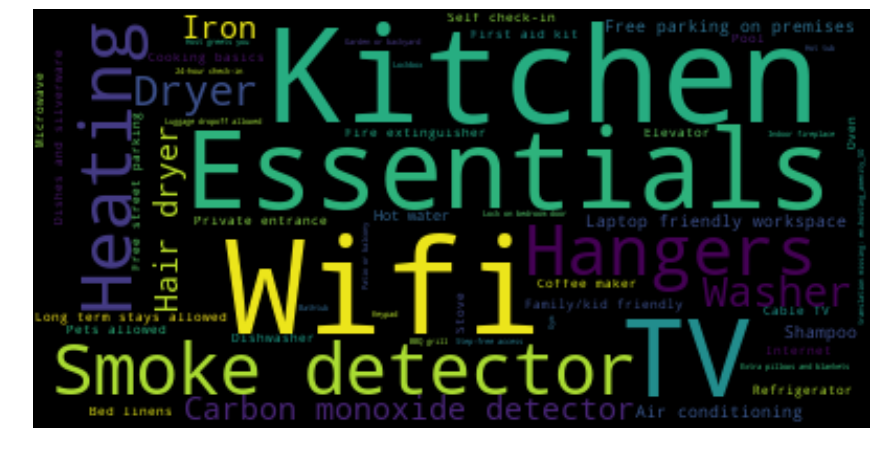

In [23]:
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=amenitiesDict)
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### __2.2.2 Amenities Bar Plot__

- We made the below bar plot to further look at amenities count. The dotted red line indicates that half the count of all listings. The result is as we expected: many top listed amenities are common to all household. Yet among them, we believe that some amenities are in particular essential to determine the long-term rent of a property since we are only interested in long-term rental. We will explore selected amenities in the next several sections.

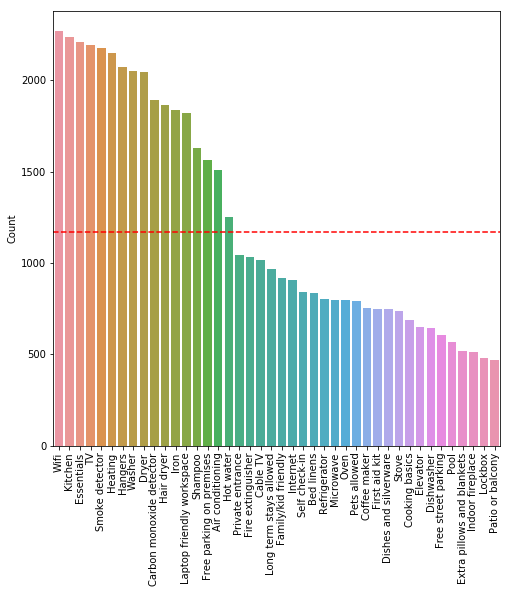

In [24]:
#amenitiesFinal.sort_values(by = 'Count', ascending = False).plot(kind = 'bar')
amenitiesFinal = amenitiesFinal.sort_values(by = 'Count', ascending = False)
plt.figure(figsize = (8, 8))
sns.barplot(x = amenitiesFinal.index, y = amenitiesFinal.Count, data = amenitiesFinal)
plt.xticks(rotation = 90)
plt.axhline(y = 2338/2, color = 'red', linestyle = '--')

### __2.3.1 Geographical Heatmap - Locations__

- Below is a heatmap that indicates the locations of all listings. The output is in html form that will be generated in the same folder of this notebook. As we can see that Santa Monica, Beverly Hills, and Downtown are the most popular places. Basically, the pattern correspond to the demographic pattern of Los Angeles county.

In [25]:
#https://eatsleepdata.com/how-to-generate-a-geographical-heatmap-with-python
latitudes = listing2Origin["latitude"]
longitudes = listing2Origin["longitude"]

# Creating the location we would like to initialize the focus on. 
# Parameters: Lattitude, Longitude, Zoom
gmap = gmplot.GoogleMapPlotter(34.0522, -118.2437, 10)

# Overlay our datapoints onto the map
gmap.heatmap(latitudes, longitudes)

# Generate the heatmap into an HTML file
gmap.draw("LA_Housing_Locations_heatmap.html")

### __2.3.2 Geographical Heatmap - Price__

- Below is an interactive heatmap that plots the price of all listings. As we zoom in, the pattern is clear: properties are most expensive along coastal line, such as Santa Monica, Venice, Hermosa Beach, Long Beach, Manhattan Beach. Among those, Santa Monica is the most expensive since it is most populated, and it is closest to the central region of Los Angeles. Besides, Beverly Hills, Downtown, and Hollywood areas are more expensive as we expected. Future airbnb tourists can refer to this heatmap to obtain a general understanding of the price of airbnbs in Los Angeles.

In [26]:
#https://alcidanalytics.com/p/geographic-heatmap-in-python
hmap = folium.Map(location=[34.0522, -118.2437], zoom_start=7)
max_amount = float(listing.final_price.max())
hm_wide = folium.plugins.HeatMap( list(zip(listing2.latitude.values, listing2.longitude.values, listing.final_price.astype(float).values)),
                   min_opacity=0.2,
                   max_val=80000,
                   radius=17, blur=15, 
                   max_zoom=1, 
                 )
hmap.add_child(hm_wide)

### __2.4.1 Final Price vs. City Boxplot__ 

- Before making any graphs that use city varaible, we found that the 'city' column of each listing has some inaccuracies. For example, there are 'Sherman Oaks,' and 'Sherman Oaks' under the 'city'. There are also two city of Santa Monica, one with a space at the end and the other without the space. To ensure accuarcy of the analysis, we first cleaned those inaccurate inputs. 

In [27]:
listing.loc[listing['city']=='Sherman Oaks, ','city'] = 'Sherman Oaks'
listing.loc[listing['city']=='Santa Monica ','city'] = 'Santa Monica'
listing.loc[listing['city']=='Hollywood ','city'] = 'Hollywood'
listing.loc[listing['city']=='Venice beach ','city'] = 'Venice Beach'
listing.loc[listing['city']=='Venice Beach','city'] = 'Venice'
listing.loc[listing['city']=='Studio City ','city'] = 'Studio City'
listing.loc[listing['city']=='Los Angeles, Woodland Hills ','city'] = 'Woodland Hills'
listing.loc[listing['city']=='LA','city'] = 'Los Angeles'
listing.loc[listing['city']=='arcadia','city'] = 'Arcadia'
listing.loc[listing['city']=='Arcadia ','city'] = 'Arcadia'
listing.loc[listing['city']=='Los Angeles County','city'] = 'Los Angeles'
listing.loc[listing['city']=='SAN PEDRO','city'] = 'San Pedro'
listing.loc[listing['city']=='Topanga Canyon','city'] = 'Topanga'
listing.loc[listing['city']=='Valencia','city'] = 'Santa Clarita'
listing.loc[listing['city']=='Chicago','city'] = 'New Chicago'
listing.loc[listing['city']=='North Hollywood ','city'] = 'North Hollywood'
listing.loc[listing['city']=='Playa del Rey','city'] = 'Playa Del Rey'
listing.loc[listing['city']=='Venice ', 'city'] = 'Venice'
listing.loc[listing['neighbourhood_cleansed']=='Torrance', 'city'] = 'Torrance'
listing.loc[listing['neighbourhood_cleansed']=='Palos Verdes Estates', 'city'] = 'Palos Verdes Estates'

- After cleaning the cities, we wanted to plot a boxplot that shows the relationship betewen city and final price. Since there are some cities with only a few listings, we filtered out the cities with less than 5 listings and analyzed the relationship of the rest. According to the boxplot below, Malibu and ManhattanBeach have the highest median price. We also found some cities with lots of outliers, such as Santa Monica. Outliers usually play important rule in data analysis, so we decided to further investigate the cities with lots of outliers in listing price, including Santa Monica, Los Angeles, and Beverly Hills. 

- Note: We changed the ylim to (0,40000) because there is only a few outliers that exceeds $40000 monthly rents, so we decided to cut the graph at 40000 so that the rest boxplots are more visually clear.

In [28]:
a = listing.city.value_counts() >= 5
a = pd.DataFrame({'city': a})
b = a.loc[a.city == True].index

In [29]:
listing_city = listing.loc[listing.city.isin(b)]

Text(0.5, 1.0, 'Price Distribution among Cities with Listing Frequency > 5')

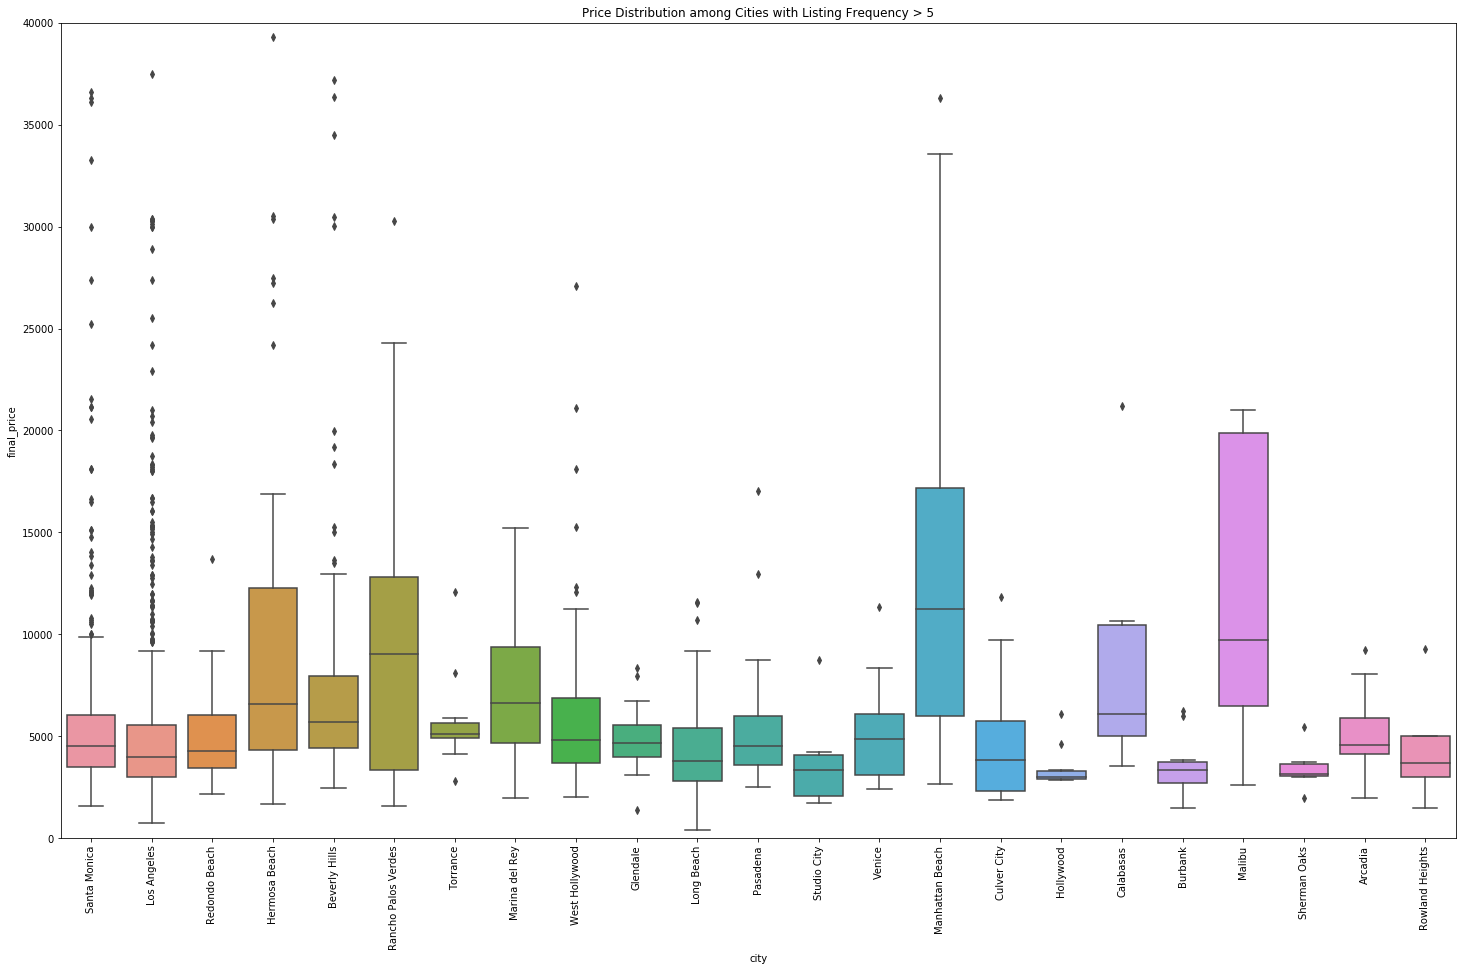

In [30]:
plt.figure(figsize = (25, 15))
sns.boxplot(x = 'city', y = 'final_price', data = listing_city )
plt.xticks(rotation = 90)
plt.ylim(0,40000)
plt.title('Price Distribution among Cities with Listing Frequency > 5')

### 2.4.2 Final Price vs. Neighbourhood Boxplot
- __City of Los Angeles__:
For city of Los Angeles, there are 80 neighbourhoods and we filtered out neighbourhoods with less than 10 listings. The graph suggests that Hollywood Hills West, Brentwood, and West Los Angeles are the most expensive neighbourhoods. Hollywood Hills West has some extremly high price property. We susepct the reason to be the famousity of Hollywood and the good view on the hill. Also, the unusual amount of outliers displayed in several particular neighbourhoods including Hollywood, Hollywood Hills, Brentwood and Westwood may result from the popularity. For example, there is a university located nearby or it is a famous tourist spot. 


In [31]:
# LA
LA = listing.loc[listing.city == 'Los Angeles']
LA_a = LA.neighbourhood_cleansed.value_counts() >= 10
LA_a = pd.DataFrame({'neighbourhood': LA_a})
LA_b = LA_a.loc[LA_a.neighbourhood == True].index
listing_LA = LA.loc[LA.neighbourhood_cleansed.isin(LA_b)]

Text(0.5, 1.0, "Price Distribution among LA's neighbourhood with Listing Frequency >= 10")

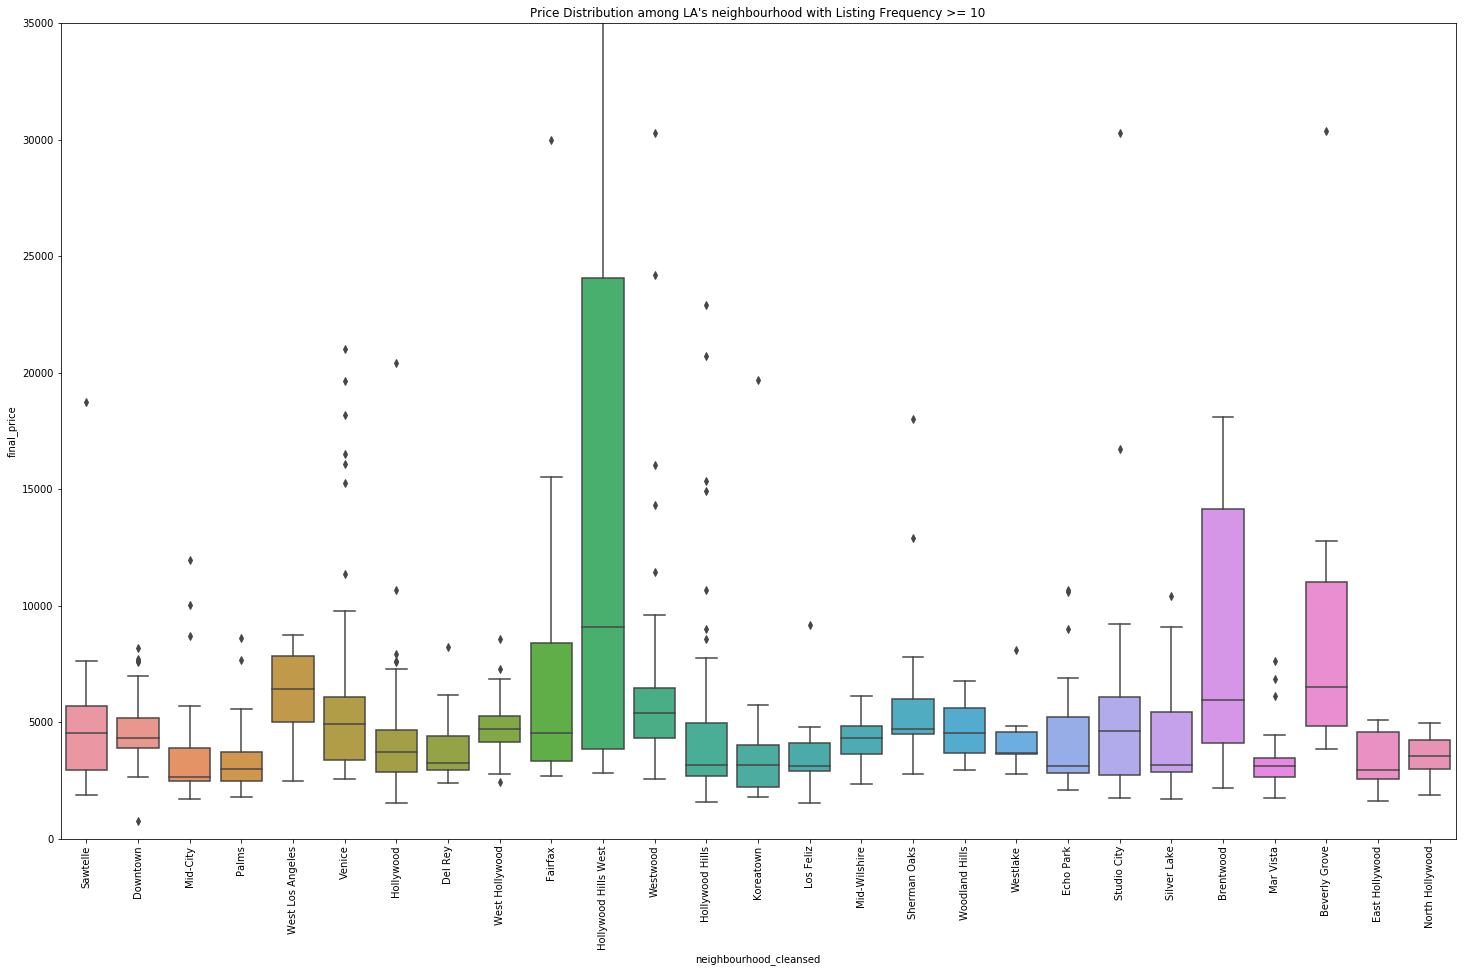

In [32]:
# LA's plot
plt.figure(figsize = (25, 15))
sns.boxplot(x = 'neighbourhood_cleansed', y = 'final_price', data = listing_LA)
plt.xticks(rotation = 90)
plt.ylim((0,35000))
plt.title('Price Distribution among LA\'s neighbourhood with Listing Frequency >= 10')

- __Beverly Hills__:
For city of Beverly Hills, as the home to many celebrities, luxury hotels, and the Rodeo Drive shopping district, has some extremely luxury and fancy properties which largely drive up the price of a few listings.

Text(0.5, 1.0, "Price Distribution among Beverly Hill's neighbourhood")

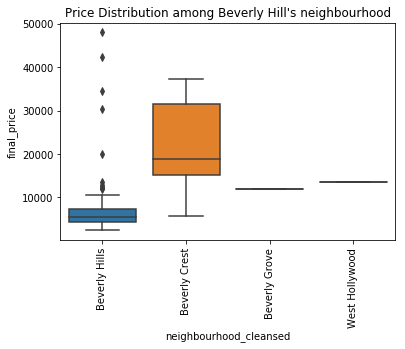

In [33]:
# Beverly Hills
BH = listing.loc[listing.city == 'Beverly Hills']
BH.loc[BH.neighbourhood_cleansed == 'West Hollywood']
sns.boxplot(x = 'neighbourhood_cleansed', y = 'final_price', data = BH)
plt.xticks(rotation = 90)
plt.title('Price Distribution among Beverly Hill\'s neighbourhood')

- __Santa Monica__: We spotted several neighbourhood mismatches within the cities during the analysis. For example, Brentwood is listed under the wrong city. Besides that, the reason Santa Monica has so many outliers, we suspect, is its popularity. The properties near the Santa Monica Pier, the famous tourist spot, are going to be very expensive. However, since Santa Monica is a large city in LA, it also has many cheaper properties for residents. Therefore, the price range in Santa Monica is very large.

Text(0.5, 1.0, "Price Distribution among Santa Monica's neighbourhood with Listing Frequency")

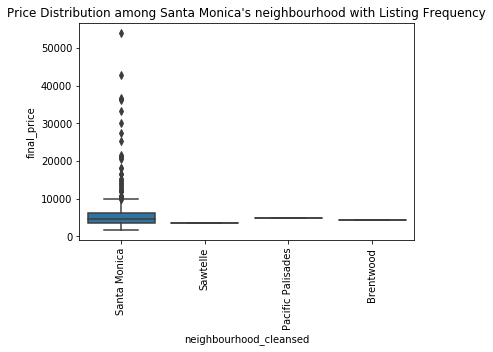

In [34]:
# Santa Monica
SM = listing.loc[listing.city == 'Santa Monica']
sns.boxplot(x = 'neighbourhood_cleansed', y = 'final_price', data = SM)
plt.xticks(rotation = 90)
plt.title('Price Distribution among Santa Monica\'s neighbourhood with Listing Frequency')

### 2.4.3 Final Price vs. Other Numerical Variables


- Before exploring the relationship between the numerical variables and the final price, we found that there are two rows with  with NaNs under bathrooms and beds. Since the number is very small, so we simply dropped those two rows.

In [35]:
listing = listing.dropna(subset = ['bathrooms','beds','bedrooms', 'accommodates'])

In [36]:
# check the correlation between potential variabels and final_price
listing[['final_price', 'bedrooms', 'bathrooms','review_scores_rating', 'accommodates', 'beds']].corr()

,final_price,bedrooms,bathrooms,review_scores_rating,accommodates,beds
final_price,1.000000,0.599114,0.671638,0.016831,0.538917,0.492380
bedrooms,0.599114,1.000000,0.790470,-0.032629,0.817309,0.775777
bathrooms,0.671638,0.790470,1.000000,0.006068,0.709354,0.654419
review_scores_rating,0.016831,-0.032629,0.006068,1.000000,-0.063650,-0.057861
accommodates,0.538917,0.817309,0.709354,-0.063650,1.000000,0.806995
beds,0.492380,0.775777,0.654419,-0.057861,0.806995,1.000000


- The correlation matrix shows the relationship between the numerical variables we have and the final price. From the martrix, we see that bedrooms, bathrooms, accommodates, and beds all have a relatively high correlation with final price. We want to plot the relationship as well to get visual results.

__Beds__

Text(0.5, 1.0, 'Relationship between number of beds and Final Price')

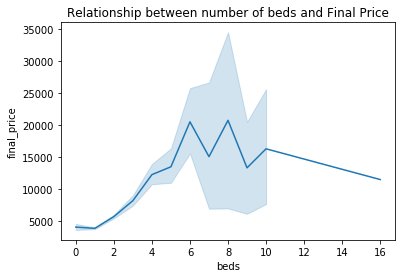

In [37]:
sns.lineplot(x = 'beds', y = 'final_price', data = listing)
plt.title("Relationship between number of beds and Final Price")

__Accommodates__

Text(0.5, 1.0, 'Relationship between number of Accommodates and Final Price')

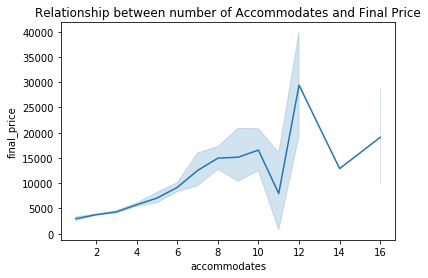

In [38]:
sns.lineplot(x = 'accommodates', y = 'final_price', data = listing)
plt.title("Relationship between number of Accommodates and Final Price")

- According to the two plots above, the relationships between number of beds, the number of accommodates and final price are not very strong. Therefore, although they have a correlation of aprroximately 0.5 with the final price, they still may not be good predictors of final price.

__Bedrooms__

Text(0.5, 1.0, 'Relationship between number of bedrooms and Final Price')

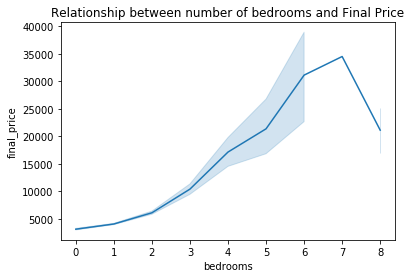

In [39]:
sns.lineplot(x = 'bedrooms', y = 'final_price', data = listing)
plt.title("Relationship between number of bedrooms and Final Price")

__Bathrooms__

Text(0.5, 1.0, 'Relationship between number of bathrooms and Final Price')

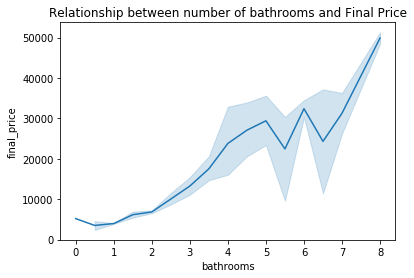

In [40]:
sns.lineplot(x = 'bathrooms', y = 'final_price', data = listing)
plt.title("Relationship between number of bathrooms and Final Price")

- There seem to be positive relationships between the number of bedrooms, bathrooms and the final price, which confirms the correlation we had earlier. Indeed, since the square footage of the house is unknown in the dataset, number of bedrooms and bathrooms are good proxies of the square footage. Therefoer, we will include bedrooms and bathrooms into our modeling process.

__Review Scores Rating__

Text(0.5, 1.0, 'Relationship between ratings and Final Price')

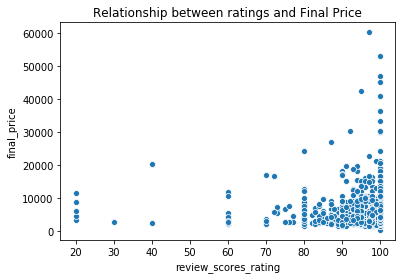

In [41]:
sns.scatterplot(x = 'review_scores_rating', y = 'final_price', data = listing)
plt.title("Relationship between ratings and Final Price")

- The realtionship between ratings and final price is unclear, aligning with the correlation we had earlier. Since all the ratings are high, mostly above 90, we lose a lot of information. Thus, ratings is not a good predictor of the final price.

### 2.4.4 Other Categorical Variables Exploration
- After analyzing the relationship between numerical variables and final price, we wanted to see the relationship between categorical variables and final price. We have many categorical variables in our dataset, so it is important to choose the right ones to go further.

__Instant_bookable__

(0, 15000)

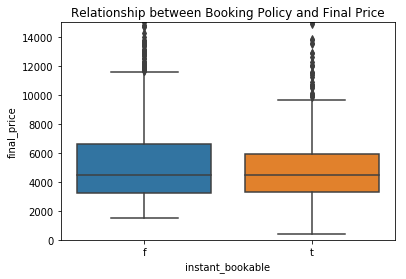

In [42]:
sns.boxplot(x = 'instant_bookable', y='final_price', data = listing)
plt.title("Relationship between Booking Policy and Final Price")
plt.ylim(0,15000)

- From the above boxplot, we see that if the property is instant bookable does not seem to affect the price of the property. So we are not going to use it as predictor of final price.

__Property Type__

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

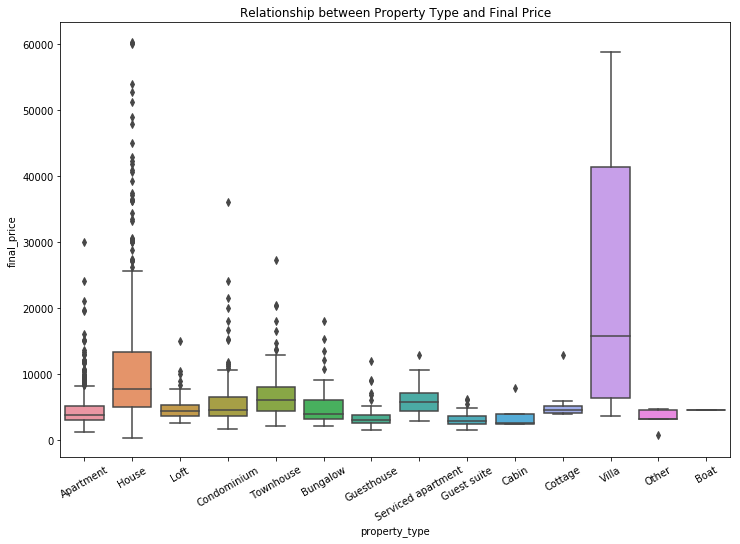

In [43]:
plt.figure(figsize = (12, 8))
sns.boxplot(x = 'property_type', y='final_price', data = listing)
plt.title("Relationship between Property Type and Final Price")
plt.xticks(rotation = 30)

- There are multiple property types, and from the boxplot, we can see that the type does affect the price of the property a lot. It makes sense since villa and houses usually are more luxurious and expensive than apartment and condo. Therefore, property type can be a good predictor of final price.

__Host is superhost?__

(0, 15000)

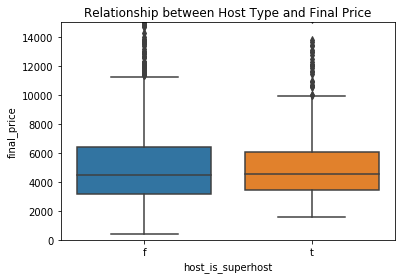

In [44]:
sns.boxplot(x = 'host_is_superhost', y='final_price', data = listing)
plt.title("Relationship between Host Type and Final Price")
plt.ylim(0,15000)

- There is little difference between the price of superhosts' property and non-superhosts' property.

### 2.5 Interactions

- In this section, we want to explore whether having a pool makes a difference in different cities. 

In [45]:
listing['pool']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Pool'])))

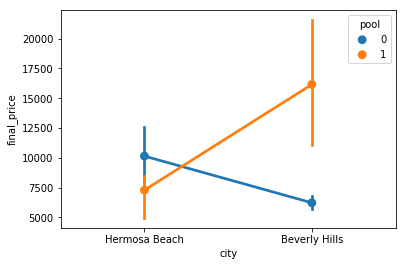

In [46]:
subset= listing.loc[(listing['city']=='Hermosa Beach') | (listing['city']=='Beverly Hills'),:]
interaction = sns.pointplot(x="city", y="final_price", hue="pool", data=subset )

- The above interaction plot indicates a strong interaction between pool and location. We picked two cities that are similarly expensive, but one close to the beach, the other in land. As the above interaction plot suggests, having a pool in a Hermosa Beach does not make a significant difference in listing price, while having a pool in Beverly Hills will substantially raise the price.

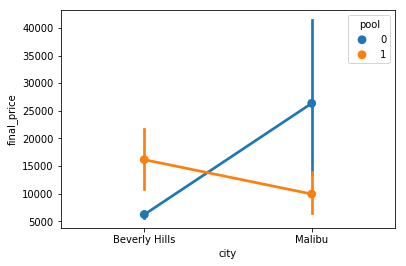

In [47]:
subset= listing.loc[(listing['city']=='Malibu') | (listing['city']=='Beverly Hills'),:]
interaction = sns.pointplot(x="city", y="final_price", hue="pool", data=subset)

- In this case, there is also a strong interaction between pool and location. However, properties with pools in Malibu have a generally lower price than those without a pool. We discovered that, in Malibu, some properties without pools are very close to the coastal line and hence have higher listing prices. 

## 3. Data Modeling

### 3.1 Add selected Amenities as categorical variables

- __amenitiesNew__: To extract more information from the variable __amenity__, we select some amenties that we believed will make a difference in listing price and created new dummy variables. 

In [48]:
listing['pool']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Pool'])))
listing['free_parking']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Free parking on premises'])))
listing['pets_allowed']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Pets allowed'])))
listing['washer']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Washer'])) )
listing['dryer']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Dryer'])) )
listing['fireplace']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Indoor fireplace'])))
listing ['patio/balcony']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Patio or balcony'])))
listing ['private_entrance']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Private entrance'])))
listing['longterm_stay_allowed']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Long term stays allowed'])))
listing ['family/kid_friendly']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Family/kid friendly'])))
listing['internet']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Internet'])))
listing['self_checkin']=listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Self check-in'])))
listing['elevator']= listing.amenitiesNew.apply(lambda x: len(set(x) & set(['Elevator'])))

### 3.2.1 Add selected cites as a new categorical varibale 

- Add variable '__city_selected__': In our exploratory analysis, we found that a few cities are obviously more expensive than others, such as Malibu, Santa Monica, Hermosa Beach, etc. We also realized that except those few cities, others do not have a huge difference in price distribution. Therefore, in order to reduce model complexity in our modeling process, we created a new column ‘city_selected’ that only differentiate those few cities and categorize the rest to ‘others’. In this way, we believe that we can not only capture the location differentiation, but also avoid computation complexity.

In [49]:
selected=['Beverly Hills','Gardena','Hermosa Beach','Malibu','Manhattan Beach','Oakland','Santa Monica','West Hollywood']
listing['city_selected']=listing.city
listing.loc[listing['city'].apply(lambda x: x not in selected), 'city_selected'] = 'Others'

### 3.2.2 Select best estimators

- To build our multiple linear regression model, we want to compare between the importance of our categorical variables. In this section, we ranked our categorical predictors by their F value in descending order to select some potential variables. This rank served as a reference for us to build the model in the next section.

In [61]:
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = sklearn.feature_selection.SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores 
cities=pd.get_dummies(data=listing.city_selected)
data=listing[['final_price','bedrooms','bathrooms','pool','free_parking','pets_allowed','washer','dryer','fireplace','patio/balcony','private_entrance','longterm_stay_allowed','family/kid_friendly','elevator']]
data=data.join(cities)
regression_score=select_kbest_reg(data,'final_price',k=5)

regression_score.sort_values(by='F Score',ascending=False)




,F Score,P Value,Attribute
0,2315.245766,0.000000e+00,bedrooms
1,2237.524056,0.000000e+00,bathrooms
7,441.328445,7.571999e-90,fireplace
3,136.878481,9.190666e-31,free_parking
6,117.321768,1.049304e-26,dryer
5,113.905938,5.413336e-26,washer
16,97.822876,1.272342e-22,Manhattan Beach
18,97.107856,1.799333e-22,Others
11,74.049583,1.379372e-17,family/kid_friendly
4,47.016130,8.992949e-12,pets_allowed


### 3.2.3 Model Building

- For our first model, we added in all the variables that have a large F value and those we believed to be significant.

In [51]:
m1 = smf.ols(formula='final_price ~  bedrooms + bathrooms + fireplace + free_parking + city_selected + dryer + pets_allowed + pool', data=listing)
res1 = m1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:            final_price   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     158.1
Date:                Wed, 05 Jun 2019   Prob (F-statistic):               0.00
Time:                        00:59:18   Log-Likelihood:                -22696.
No. Observations:                2324   AIC:                         4.542e+04
Df Residuals:                    2308   BIC:                         4.552e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- We examined the p-value of each variable and remove insignificant variables one by one to refine our model. In addition, we performed log transformation on the y variable to reduce the volatility in prices.

In [92]:
listing['final_price_log'] = np.log(listing[['final_price']])
m2 = smf.ols(formula='final_price_log ~  bedrooms + bathrooms + fireplace  + city_selected + dryer + pets_allowed + pool', data=listing)
res2 = m2.fit()
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:        final_price_log   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     266.8
Date:                Wed, 05 Jun 2019   Prob (F-statistic):               0.00
Time:                        01:13:58   Log-Likelihood:                -926.10
No. Observations:                2324   AIC:                             1882.
Df Residuals:                    2309   BIC:                             1968.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- Initially, we reduced the levels of cities to four because we want to have a simpler model. To see if this tranformation loses too much information, we did another transformation that includes all cities. 

In [62]:
m3 = smf.ols(formula='final_price_log ~  bedrooms + bathrooms + fireplace  + city + dryer + pets_allowed + pool', data=listing)
res3 = m3.fit()
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:        final_price_log   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     57.29
Date:                Wed, 05 Jun 2019   Prob (F-statistic):               0.00
Time:                        01:02:22   Log-Likelihood:                -833.81
No. Observations:                2322   AIC:                             1814.
Df Residuals:                    2249   BIC:                             2233.
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

- Comparing m2 and m3, we found that although the R-square has increased from 0.03, it is not significant enough to sacrifice the model simplicity. Therefore, we decided to use city_selected eventually. In m5, we also added interaction term between property type and city(selected) because we believed that different areas have different property type characteristics.

In [74]:
m5= smf.ols(formula='final_price_log ~  bedrooms + bathrooms + fireplace + city_selected + dryer + pets_allowed + pool + property_type:city_selected + property_type' , data=listing)
res5 = m5.fit()
print(res5.summary())

                            OLS Regression Results                            
Dep. Variable:        final_price_log   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     56.61
Date:                Wed, 05 Jun 2019   Prob (F-statistic):               0.00
Time:                        01:10:08   Log-Likelihood:                -832.60
No. Observations:                2324   AIC:                             1813.
Df Residuals:                    2250   BIC:                             2239.
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                                                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

### 3.2.4 Check Diagnostic Plots 

- We prefer m5, which is the last model we built in previous section since it gives the highest R square and it captures all important information we want, including appropriate interation. To determine if this model is valid, we need to check the diagnostic plots to make sure there is no linear model assumption violation

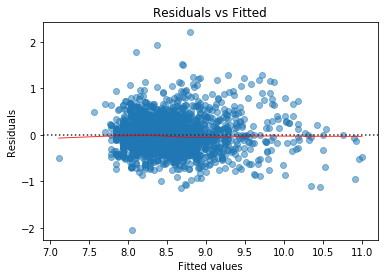

In [75]:
model_fitted_y = res5.fittedvalues
# model residuals
model_residuals = res5.resid
# normalized residuals
model_norm_residuals = res5.get_influence().resid_studentized_internal
# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
# absolute residuals
model_abs_resid = np.abs(model_residuals)
# leverage, from statsmodels internals
model_leverage = res5.get_influence().hat_matrix_diag
# cook's distance, from statsmodels internals
model_cooks = res5.get_influence().cooks_distance[0]

plot_lm_1 = plt.figure()
plot_lm_1.axes[0] = sns.residplot(model_fitted_y, listing.columns[-1], data=listing,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

In [76]:
model_norm_residuals[~np.isfinite(model_norm_residuals)] = 0

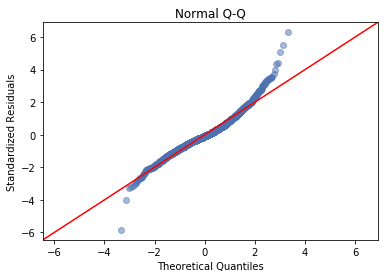

In [77]:
from statsmodels.graphics.gofplots import ProbPlot
QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');

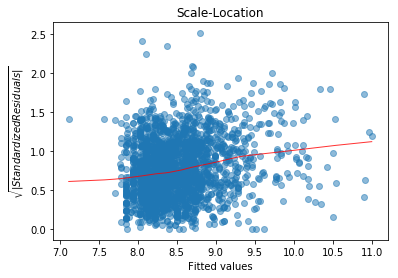

In [78]:
plot_lm_3 = plt.figure(3)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');


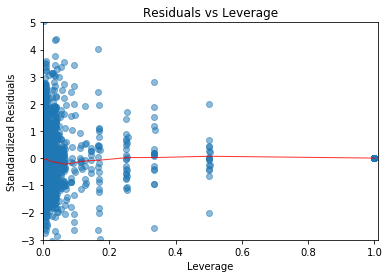

In [79]:
model_leverage
plot_lm_4 = plt.figure();
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5);
sns.regplot(model_leverage, model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
plot_lm_4.axes[0].set_xlim(0, max(model_leverage)+0.01)
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals');


- The diagnostic plots are quite positive. There is no violation of the assumption that errors are randomly distributed since the first plot shows randomness. Though the normal Q-Q plot shows a little deviation at the front and back tails, it still follows a relatively normal distribution. The third plot has a little upward trend, but we can accept that little violation. The fourth plot shows almost no bad leverage point. Overall, the model we built is valid. 

- Note: codes to create the diagnostic plots are referenced from Emre Can: https://medium.com/@emredjan/emulating-r-regression-plots-in-python-43741952c034

### 3.2.5 MLR Cross Validation 

- Model 5 in previous section is our most satisfactory one, so we decided to do Cross Validation on this model to test its validity.

In [80]:
from sklearn.model_selection import train_test_split
import sklearn.metrics as skl

- Note: Set random state to allow replication of work.

In [88]:
X = listing[['bedrooms','bathrooms', 'fireplace','city_selected', 'dryer', 'pets_allowed','pool', 'property_type']]
y = np.log(listing[['final_price']])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
training = X_train.join(y_train)

In [89]:
model= smf.ols(formula='final_price ~  city_selected + bedrooms + bathrooms + fireplace + dryer + pets_allowed + pool + property_type:city_selected + property_type', data=training)
m = model.fit()
print('training_R2: ', m.rsquared)

training_R2:  0.6517927936110526


In [90]:
y_predict = m.predict(X_test)
print('testing_R2: ',skl.r2_score(y_test, y_predict))

testing_R2:  0.6204345332372172


- The above cross validation process shows that our training dataset has achieved a R-square of 0.65, while the testing dataset has achieved a R-square of 0.62. There is only a small difference between the score of the training and testing datasets. So our model is valid. 

### 3.3.1 Model Using Decision Tree & Random Forest

- We wish to explore a regression model using deep learning methods decision tree and random forest as a supplement to the MLR model, and to compare with the MLR model.

In [63]:
#https://nbviewer.jupyter.org/github/srnghn/ml_example_notebooks/blob/master/Predicting%20Yacht%20Resistance%20with%20Decision%20Trees%20%26%20Random%20Forests.ipynb
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt

In [64]:
listing.loc[:, 'security_deposit'] = listing.security_deposit.str.replace('$', '').str.replace(',', '').astype(float)

In [65]:
listing.loc[listing.security_deposit.isna(), 'security_deposit'] = 0

In [66]:
listing = listing.drop(listing[listing.city.isna()].index, axis = 0)

- As decision tree and random forest can only work with numerical inputs, we believe that by adding more numerical variables will bring out a better performance, so on top of the variables that MLR model had, we further added host_listings_count, number_of_reviews, which can partially represent the popularity of a property, and security_deposit, as lower security deposit may lure more people.
- We took the square root of final_price to do a power transform as it increases R-squared, and it made sense since final_prices are huge numbers.

In [69]:
X = listing[['pool','pets_allowed','private_entrance','elevator','city', 'bedrooms', 'bathrooms', 'host_listings_count', 'number_of_reviews', 'security_deposit']].values
y = np.sqrt(listing[['final_price']].values)

- We used __labelEncoder__ to convert the variable city to numerics by labelling a unique number to each city.

In [70]:
le = LabelEncoder()
le.fit(listing.city.unique())
X[:, 4] = le.transform(X[:, 4])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
#Standardizing the inputs.
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [73]:
#Create regressor.
tree_model = DecisionTreeRegressor()
rf_model = RandomForestRegressor()

In [74]:
#Fit training datasets.
tree_model.fit(train_scaled, y_train)
rf_model.fit(train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

- We wanted to see which of these predictors contribute most to explain the final price, so we created the below __feature importance__ plot. As we can see the most important predictor is number of bathrooms and bedrooms, followed by number_of_reviews and city. It makes sense that the higher the number of bathrooms and bedrooms, the larger the property, hence more expensive.

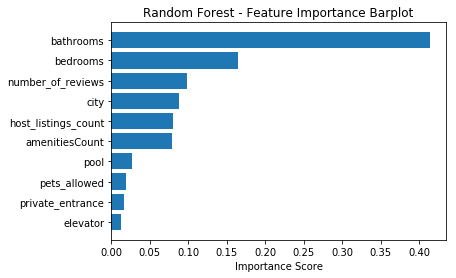

In [75]:
names = ['pool','pets_allowed','private_entrance','elevator','city', 'bedrooms', 'bathrooms', 'host_listings_count', 'amenitiesCount', 'number_of_reviews', 'security_deposit']
importance = dict(sorted(zip(map(lambda x: round(x, 4), rf_model.feature_importances_), names)))
lists = sorted(importance.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.barh(y,x)
plt.xlabel('Importance Score')
plt.title('Random Forest - Feature Importance Barplot')
plt.show()

In [76]:
tree_mse = mean_squared_error(y_train, tree_model.predict(train_scaled))
tree_mae = mean_absolute_error(y_train, tree_model.predict(train_scaled))
rf_mse = mean_squared_error(y_train, rf_model.predict(train_scaled))
rf_mae = mean_absolute_error(y_train, rf_model.predict(train_scaled))

In [77]:
print("Decision Tree training MeanAbsoluteError = ",tree_mae," & MeanSquareError = ", tree_mse, 'R-squared = ', 1-tree_mse/(np.var(y_train)))
print("Random Forest training MeanAbsoluteError = ",rf_mae," & MeanSquareError = ", rf_mse, 'R-squared = ', 1-rf_mse/(np.var(y_train)))

Decision Tree training MeanAbsoluteError =  0.40178284255570373  & MeanSquareError =  2.1990911368245234 R-squared =  0.9965585631120011
Random Forest training MeanAbsoluteError =  4.437077258886608  & MeanSquareError =  59.031421450360604 R-squared =  0.9076196034223332


In [78]:
tree_test_mse = mean_squared_error(y_test, tree_model.predict(test_scaled))
tree_test_mae = mean_absolute_error(y_test, tree_model.predict(test_scaled))
rf_test_mse = mean_squared_error(y_test, rf_model.predict(test_scaled))
rf_test_mae = mean_absolute_error(y_test, rf_model.predict(test_scaled))

In [79]:
print("Decision Tree test MeanSquareError = ",tree_test_mse," & MeanAbsoluteError = ",tree_test_mae, 'R-squared = ', 1-tree_test_mse/(np.var(y_test)))
print("Random Forest test MeanSquareError = ",rf_test_mse," & MeanAbsoluteError = ",rf_test_mae, 'R-squared = ', 1-rf_test_mse/(np.var(y_test)))

Decision Tree test MeanSquareError =  683.2249662658855  & MeanAbsoluteError =  15.568817321436176 R-squared =  0.2362957971973474
Random Forest test MeanSquareError =  374.3693056451465  & MeanAbsoluteError =  11.708679614499593 R-squared =  0.5815325460307539


- From the above result, we can see that the R-square of test dataset is much lower than the training dataset, which indicate that the model might be overfitting. The overfitting problem is severe as the training dataset has a result of 99% and 90%. Also, as expected, random forest performed much better than decision tree for testing data. Yet both models are outperformed by the MLR model, and we suspect that the reson might be that decision tree & random forest are more useful with non-linear relationships.

## 4. Conclusion and Limitation
<p>Our exploratory process found a close relationship between the location of the property and the monthly price. We did a lot of data cleaning to eliminate any city replications due to mistaken input. We also did some cleaning on the prices of the property by filling NaN and eliminating unusual listings. We also found a few amenities to be relevant to price determination such as pool, washer/dryer, pets allow, free parking etc. So we subjectively selected several amenities and built them as categorical variables in our listing dataset.<p>

<p>From the exploratory analysis, we successfully narrowed down the variables of interest from 106 in the original datasets to less than 20. Our goal of the analysis is to provide insights on how to set a reasonable price for the property for future hosts. We tried different modeling methods to achieve that goal. We did Multiple Linear Regression, Random Forest, and Decision Tree and compared for the results. For MLR, our modeling process involved several statistical techniques including variable transformation, adding interaction term, and cross validation. By doing cross validation with 80% training data and 20% testing data, we were able to achieve a R-square of more than 60% in both datasets, indicating our variables have explained more than 60% of the variation of the properties’ final monthly prices. <p>

<p>For Decision Tree and Random Forest, since random forest has a much more complexed algorithm, it outperformed decision tree, yet there are several limitations to it. Firstly, as random forest only accepts numerical predictors, converting the categorical variables to numerical impacts the accuracy of the model. Secondly, random forest and decision trees tend to overfit, compared with MLR, althought it performed very well for the training dataset. Decision tree achieved an R-square of 99%, and random forest 90%. As a conclusion, since there are not many insightful numerical variables in this listing dataset, and most variables we selected are categorical, it is more appropriate to use the MLR model compared with decision tree and random forest.

<p>Though we believe that our models can help hosts to determine price, our models can be further improved in multiple ways. Time factor plays an very important role on price determination. A same property may have different price depending on the season of the book. Holiday seasons, such as Thanksgiving, Christmas, and long weekends, tend to have higher price than usual. However, seasonality is not captured by the dataset we currently have, since it only provides general information of each listing instead of each transaction made in the past, so we could not implement time as a factor to our model. In the future, if applicable, we would extend our analysis by adding seasonality into our modeling process. Moreover, more time allowed, we would want to investigate short-term listings as well (listings with minimum nights less than 30 days).By including those listings, we could further investigate the preference of short-term tenants. With that taken into accounts, we could also add the information of nearby hotels to our consideration, since the two choices for most people who are looking for short-term stry in LA are hotels and Airbnbs. Therefore, we could analyze the competitions from local hotels and study their effects on Airbnb properties. We can also try different machine learning models to have a better prediction results if we have more time.<p>

